<a href="https://colab.research.google.com/github/jhanv/Cypto_RoboAdvisor/blob/main/MLP_for_crypto_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The central goal is to analyse the cryptomarket and see if a deep learning model can predict the fluctuation of prices in conjunction with sentiment data. To this end, we hope to construct a few models (In this notebook we are exploring with MLP) of varying complexity to help learn the patterns (if any) and help eliminate some of the uncertainty of this market. We believe that crypto currencies would have a prominent position in the future of finance and this paper would shed light into how people view the currency.

The simplest model option: a MLP model. Since a MLP model does not have any inbuilt time-series attention mechanism, it is the simplest model that could be used for our task. After experimentation and hypertuning, we decided on using ReLU activation, MSE loss, Adam optimization, and a learning rate of around 3e-5. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
# imports
import os
import csv
import json
import random
import pathlib

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import HTML, display

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cpu'), 1)

# Helper Functions

In [ ]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def progress(epoch, loss, epochs=100):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{epoch}'
            max='{epochs}',
            style='width: 100%'
        >
            {epoch}
        </progress>
    """.format(loss=loss, epoch=epoch, epochs=epochs))

# Loading Data

In [ ]:
def download_data(sentiment):
  df = pd.read_csv("/content/drive/MyDrive/CIS 522/CIS 522 Final Project/Data/bitcoin_complete.csv")
  df.head()

  df['Volume USDT'] = df['Volume USDT'].apply(lambda x : float("Nan") if x == 0 else x)  
  df['Volume USDT'] = df['Volume USDT'].interpolate(method = 'linear', limit_direction = 'forward')
  if sentiment: 
    cpt_full_df = df.iloc[:,1:]
  else: 
    cpt_full_df = df.iloc[:,1:7]

  return cpt_full_df

## Plotting (Without normalizations)

In [ ]:
# fig = plt.figure(figsize=(15,10))
# st = fig.suptitle("Crypto Close Price and Volume", fontsize=20)
# st.set_y(0.92)

# ax1 = fig.add_subplot(211)
# ax1.plot(cpt_full_df['close'], label='crypto Close Price')
# ax1.set_xticks(range(0, cpt_full_df.shape[0], 200))
# ax1.set_xticklabels(cpt_full_df['date'].loc[::200])
# ax1.set_ylabel('Close Price', fontsize=18)
# ax1.legend(loc="upper left", fontsize=12)

# ax2 = fig.add_subplot(212)
# ax2.plot(cpt_full_df['Volume USDT'], label='Crypto Volume')
# ax2.set_xticks(range(0, cpt_full_df.shape[0], 200))
# ax2.set_xticklabels(cpt_full_df['date'].loc[::200])
# ax2.set_ylabel('Volume USDT', fontsize=18)
# ax2.legend(loc="upper left", fontsize=12)

## Normalizing Data

In [ ]:
def percentage_format(cpt_full_df, sentiment):
  # Calculate

  cpt_full_df["open"] = cpt_full_df["open"].pct_change()
  cpt_full_df["close"] = cpt_full_df["close"].pct_change()
  cpt_full_df["low"] = cpt_full_df["low"].pct_change()
  cpt_full_df["high"] = cpt_full_df["high"].pct_change()
  cpt_full_df["Volume USDT"] = cpt_full_df["Volume USDT"].pct_change()

  if sentiment: 
    cpt_full_df["reddit_posts"] = cpt_full_df["reddit_posts"].pct_change()
    cpt_full_df["reddit_likes_total"] = cpt_full_df["reddit_likes_total"].pct_change()
    cpt_full_df["google_trends"] = cpt_full_df["google_trends"].pct_change()
    cpt_full_df["twitter_posts"] = cpt_full_df["twitter_posts"].pct_change()

  cpt_full_df.dropna(how="any", axis=0, inplace=True)

  return cpt_full_df

In [ ]:
def difference_format(cpt_full_df, sentiment):
  cpt_full_df["open"] = cpt_full_df["open"].diff()
  cpt_full_df["close"] = cpt_full_df["close"].diff()
  cpt_full_df["low"] = cpt_full_df["low"].diff()
  cpt_full_df["high"] = cpt_full_df["high"].diff()
  cpt_full_df["Volume USDT"] = cpt_full_df["Volume USDT"].diff()
  
  if sentiment: 
    cpt_full_df["reddit_posts"] = cpt_full_df["reddit_posts"].diff()
    cpt_full_df["reddit_likes_total"] = cpt_full_df["reddit_likes_total"].diff()
    cpt_full_df["google_trends"] = cpt_full_df["google_trends"].diff()
    cpt_full_df["twitter_posts"] = cpt_full_df["twitter_posts"].diff()

  cpt_full_df.dropna(how="any", axis=0, inplace=True)

  return cpt_full_df

In [ ]:
def normalize(cpt_full_df, sentiment):
  min_return = min(cpt_full_df[['open', 'high', 'low', 'close']].min(axis=0))
  max_return = max(cpt_full_df[['open', 'high', 'low', 'close']].max(axis=0))

  # Min-max normalize price columns (0-1 range)
  cpt_full_df['open'] = (cpt_full_df['open'] - min_return) / (max_return - min_return)
  cpt_full_df['high'] = (cpt_full_df['high'] - min_return) / (max_return - min_return)
  cpt_full_df['low'] = (cpt_full_df['low'] - min_return) / (max_return - min_return)
  cpt_full_df['close'] = (cpt_full_df['close'] - min_return) / (max_return - min_return)

  min_volume = cpt_full_df['Volume USDT'].min(axis=0)
  max_volume = cpt_full_df['Volume USDT'].max(axis=0)

  # Min-max normalize volume columns (0-1 range)
  cpt_full_df['Volume USDT'] = (cpt_full_df['Volume USDT'] - min_volume) / (max_volume - min_volume)


  if sentiment: 
    # Min max reddit stuff 
    min_volume = cpt_full_df['reddit_weighted_score'].min(axis=0)
    max_volume = cpt_full_df['reddit_weighted_score'].max(axis=0)

    cpt_full_df['reddit_weighted_score'] = (cpt_full_df['reddit_weighted_score'] - min_volume) / (max_volume - min_volume)

    min_volume = cpt_full_df['reddit_posts'].min(axis=0)
    max_volume = cpt_full_df['reddit_posts'].max(axis=0)

    cpt_full_df['reddit_posts'] = (cpt_full_df['reddit_posts'] - min_volume) / (max_volume - min_volume)

    min_volume = cpt_full_df['reddit_likes_total'].min(axis=0)
    max_volume = cpt_full_df['reddit_likes_total'].max(axis=0)

    cpt_full_df['reddit_likes_total'] = (cpt_full_df['reddit_likes_total'] - min_volume) / (max_volume - min_volume)

    min_volume = cpt_full_df['google_trends'].min(axis=0)
    max_volume = cpt_full_df['google_trends'].max(axis=0)

    cpt_full_df['google_trends'] = (cpt_full_df['google_trends'] - min_volume) / (max_volume - min_volume)

    min_volume = cpt_full_df['twitter_posts'].min(axis=0)
    max_volume = cpt_full_df['twitter_posts'].max(axis=0)

    cpt_full_df['twitter_posts'] = (cpt_full_df['twitter_posts'] - min_volume) / (max_volume - min_volume)

  return cpt_full_df

In [ ]:
def apply_transformations(cpt_full_df, sentiment):
  if data_format == 1:
    cpt_full_df = percentage_format(cpt_full_df, sentiment)
  elif data_format == 2: 
    cpt_full_df = difference_format(cpt_full_df, sentiment)    
  if normalize == 1: 
    cpt_full_df = normalize(cpt_full_df, sentiment)
  return cpt_full_df

## Splitting into train, test, and validation sets

In [ ]:
def split_data(cpt_full_df):
  per_of_test = 0.1
  per_of_val = 0.1

  times = sorted(cpt_full_df.index.values)
  last_npct = sorted(cpt_full_df.index.values)[-int(per_of_test*len(times))] # Last 10% of series
  last_2npct = sorted(cpt_full_df.index.values)[-int((per_of_val+per_of_test)*len(times))] # Last 20% of series

  df_train = cpt_full_df[(cpt_full_df.index < last_2npct)]  # Training data are 80% of total data
  df_val = cpt_full_df[(cpt_full_df.index >= last_2npct) & (cpt_full_df.index < last_npct)]
  df_test = cpt_full_df[(cpt_full_df.index >= last_npct)]

  # Remove date column
  df_train.drop(columns=['date'], inplace=True)
  df_val.drop(columns=['date'], inplace=True)
  df_test.drop(columns=['date'], inplace=True)

  closing_index=df_train.columns.get_loc('close')

  # Convert pandas columns into arrays
  train_data = df_train.values
  val_data = df_val.values
  test_data = df_test.values
  print(f'Training data shape: {train_data.shape}')
  print(f'Validation data shape: {val_data.shape}')
  print(f'Test data shape: {test_data.shape}')

  df_train.head()

  return train_data, val_data, test_data, closing_index

In [ ]:
def sequence_data(train_data, val_data, test_data, closing_index):
  # Training data
  X_train, y_train = [], []
  for i in range(seq_len+day_out_pred-1, len(train_data)):
    X_train.append(train_data[i-seq_len-day_out_pred+1:i-day_out_pred+1]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, closing_index][i]) #Value of 4th column (Close Price) of df-row 128+1
  X_train, y_train = np.array(X_train), np.array(y_train)

  ###############################################################################

  # Validation data
  X_val, y_val = [], []
  for i in range(seq_len+day_out_pred-1, len(val_data)):
      X_val.append(val_data[i-seq_len-day_out_pred+1:i-day_out_pred+1])
      y_val.append(val_data[:, closing_index][i])
  X_val, y_val = np.array(X_val), np.array(y_val)

  ###############################################################################

  # Test data
  X_test, y_test = [], []
  for i in range(seq_len+day_out_pred-1, len(test_data)):
      X_test.append(test_data[i-seq_len-day_out_pred+1:i-day_out_pred+1])
      y_test.append(test_data[:, closing_index][i])    
  X_test, y_test = np.array(X_test), np.array(y_test)

  print('Training set shape', X_train.shape, y_train.shape)
  print('Validation set shape', X_val.shape, y_val.shape)
  print('Testing set shape' ,X_test.shape, y_test.shape)
  
  return X_train, y_train, X_val, y_val, X_test, y_test

# Architecture

In [ ]:
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test):
  X_train = torch.FloatTensor(X_train.astype(float)).to(dev)
  y_train = torch.FloatTensor(y_train).to(dev)
  training_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(training_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True)

  X_val = torch.FloatTensor(X_val.astype(float)).to(dev)
  y_val = torch.FloatTensor(y_val).to(dev)
  validation_dataset = TensorDataset(X_val, y_val) 
  val_loader = DataLoader(validation_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True)

  X_test = torch.FloatTensor(X_test.astype(float)).to(dev)
  y_test = torch.FloatTensor(y_test).to(dev)
  test_dataset = TensorDataset(X_test, y_test) 
  test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True,
                          shuffle=True)
  
  return train_loader, val_loader, test_loader

In [ ]:
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        exec('self.actv = nn.%s'%actv)   # [TO-DO]

        self.layers = nn.ModuleList()
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          new_layer = nn.Linear(num_inputs, next_num_inputs)
          nn.init.xavier_normal_(new_layer.weight)
          self.layers += [new_layer]   # [TO-DO]

          # exec('actv = nn.%s'%actv)
          self.layers += [self.actv]

          new_batchnorm = nn.BatchNorm1d(next_num_inputs)
          self.layers += [new_batchnorm]

          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):
        # flattening
        x = x.view(x.shape[0], -1)   # [TO-DO]

        for layer in self.layers:
          # x = self.actv(layer(x))  # [TO-DO]
          x = layer(x)

        x = self.out(x) # [TO-DO]
        return x

In [ ]:
def train(net, criterion, optimizer,
                              train_loader, val_loader, 
                              num_epochs=1, verbose=True, 
                              training_plot=False):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  net.train()
  training_losses = []
  validation_losses = []
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      running_accuracy = 0.0
      total = 0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(dev).float()
          labels = labels.to(dev).float()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          total += labels.size(0)

          # print statistics
          if verbose:
          #   training_losses += [loss.item()]
          #   running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
          #       running_loss = 0.0

      training_losses.append(running_loss/len(train_loader))

      net.eval()
      running_loss = 0.0
      total = 0
      for data in val_loader:
          inputs, labels = data
          inputs = inputs.to(dev).float()
          labels = labels.to(dev).float()


          outputs = net(inputs)

          loss = criterion(outputs, labels)

          running_loss += loss.item()
          total += labels.size(0)
          
      validation_losses.append(running_loss/len(val_loader))

      print('Training loss: %0.2f %%' % (training_losses[-1]))
      print('Validation loss: %0.2f %%' % (validation_losses[-1]))

  return training_losses, validation_losses


def test(net, data_loader):
  net.eval()
  MAE_total = 0
  MAPE_total = 0
  total = 0
  for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(dev).float()
      labels = labels.to(dev).float()

      outputs = net(inputs)
      MAE_total += (outputs - labels).abs().sum().item()
      MAPE_total +=  ((labels - outputs).abs() / labels.abs()).sum().item()
      total += labels.size(0)
      
  MAE = MAE_total / total
  MAPE = MAPE_total / total
  return MAE, MAPE

In [ ]:
def train_model(X_train, train_loader, val_loader):
  net = Net(activation, X_train.shape[1] * X_train.shape[2], architecture, 1).to(dev) 
  optimizer = optim.Adam(net.parameters(), lr)
  training_losses, validation_losses  = train(net, criterion, optimizer,
                                        train_loader,val_loader,
                                        num_epochs=50)
  return net, training_losses, validation_losses 

In [ ]:
def get_results (net, train_loader, val_loader, test_loader):
  train_MAE, train_MAPE = test(net, train_loader)
  val_MAE, val_MAPE = test(net, val_loader)
  test_MAE, test_MAPE = test(net, test_loader)

  return train_MAE, train_MAPE,  val_MAE, val_MAPE,  test_MAE, test_MAPE, 

# Displaying and saving results

In [ ]:
def write_results(train_MAE, train_MAPE,  val_MAE, val_MAPE,  test_MAE, test_MAPE):
  file=open(results_folder + "/results.txt", "a+")
  file.write("%d : data_format\n" % data_format)
  file.write("%d : day_out_pred\n" % day_out_pred)
  file.write("%d : seq_len\n" % seq_len)
  file.write("%d : normalized\n" % normalization)
  file.write("\n")
  file.write("Train MAE: " + str(train_MAE) + ", MAPE: " + str(train_MAPE) + "\n")
  file.write("Validation MAE: " + str(val_MAE) + ", MAPE: " + str(val_MAPE) + "\n")
  file.write("Test MAE: " + str(test_MAE) + ", MAPE: " + str(test_MAPE) + "\n")
  file.write("\n")
  file.close()

In [ ]:
# Loss plot 
def save_lossplot (training_losses, validation_losses):
  plt.title("Losses")
  plt.plot(training_losses,label="Training loss")
  plt.plot(validation_losses, label = "Validation loss")
  plt.legend()
  plt.xlabel('Batch')
  plt.ylabel('Training loss')
  file_name = str(data_format) + " " + str(day_out_pred) + " " + str(seq_len) + " " + str(normalization) + " losses"
  plt.savefig(results_folder + "/" + file_name + ".png")
  plt.show()
  plt.close()


In [ ]:
def save_resultplot (net, X_train, y_train, X_val, y_val, X_test, y_test):
  #Calculate predication for training, validation and test data
  train_pred = net(X_train).detach().cpu()
  val_pred = net(X_val).detach().cpu()
  test_pred = net(X_test).detach().cpu()

  '''Display results'''

  fig = plt.figure(figsize=(15,20))
  st = fig.suptitle("MLP model", fontsize=22)
  st.set_y(0.92)

  #Plot training data results
  ax11 = fig.add_subplot(311)
  ax11.plot(y_train, label='Crypto Closing Returns')
  ax11.plot(train_pred, label='Predicted Crypto Closing Returns')
  # ax11.plot(train_data[:, 3], label='Crypto Closing Returns')
  # ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted Crypto Closing Returns')
  ax11.set_title("Training Data", fontsize=18)
  ax11.set_xlabel('Date')
  ax11.set_ylabel('Crypto Closing Returns')
  ax11.legend(loc="best", fontsize=12)

  #Plot validation data results
  ax21 = fig.add_subplot(312)
  ax21.plot(y_val, label='Crypto Closing Returns')
  ax21.plot(val_pred, label='Predicted Crypto Closing Returns')
  # ax21.plot(val_data[:, 3], label='Crypto Closing Returns')
  # ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted Crypto Closing Returns')
  ax21.set_title("Validation Data", fontsize=18)
  ax21.set_xlabel('Date')
  ax21.set_ylabel('Crypto Closing Returns')
  ax21.legend(loc="best", fontsize=12)

  #Plot test data results
  ax31 = fig.add_subplot(313)
  ax31.plot(y_test, label='Crypto Closing Returns')
  ax31.plot(test_pred, label='Predicted Crypto Closing Returns')
  # ax31.plot(test_data[:, 3], label='Crypto Closing Returns')
  # ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted Crypto Closing Returns')
  ax31.set_title("Test Data", fontsize=18)
  ax31.set_xlabel('Date')
  ax31.set_ylabel('Crypto Closing Returns')
  ax31.legend(loc="best", fontsize=12)

  file_name = str(data_format) + " " + str(day_out_pred) + " " + str(seq_len)+ " " + str(normalization) + " results"
  fig.savefig(results_folder + "/" + file_name + ".png")
  plt.close()

# Full process

In [ ]:
def run_everything (sentiment):
  df = download_data(sentiment)
  df = apply_transformations(df, sentiment)
  train_data, val_data, test_data, closing_index = split_data(df)
  X_train, y_train, X_val, y_val, X_test, y_test = sequence_data(train_data, val_data, test_data, closing_index)
  train_loader, val_loader, test_loader = create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test)
  net, training_losses, validation_losses = train_model(X_train, train_loader, val_loader)
  train_MAE, train_MAPE,  val_MAE, val_MAPE,  test_MAE, test_MAPE = get_results(net, train_loader, val_loader, test_loader)
  write_results(train_MAE, train_MAPE,  val_MAE, val_MAPE,  test_MAE, test_MAPE)
  save_lossplot (training_losses, validation_losses)
  X_train = torch.FloatTensor(X_train.astype(float)).to(dev)
  X_val = torch.FloatTensor(X_val.astype(float)).to(dev)
  X_test = torch.FloatTensor(X_test.astype(float)).to(dev)
  save_resultplot (net, X_train, y_train, X_val, y_val, X_test, y_test)

# RUN EVERYTHING

In [ ]:
# data_format_values is 0 for percentages, 1 for absolute numbers, 2 for differences
data_format_values = [0,1,2]
day_out_pred_values = [1,7,14]
seq_len_values = [10,20,30]
normalization_values = [0,1]

batch_size = 12
architecture = [50, 30, 10]
activation = 'ReLU()'
criterion = nn.MSELoss()
lr = 3e-5

results_folder = "/content/drive/MyDrive/CIS 522/CIS 522 Final Project/MLP Results no sentiment"

Training data shape: (1415, 5)
Validation data shape: (177, 5)
Test data shape: (176, 5)
Training set shape (1385, 30, 5) (1385,)
Validation set shape (147, 30, 5) (147,)
Testing set shape (146, 30, 5) (146,)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training loss: 23390106.52 %
Validation loss: 15591001.83 %
Training loss: 23296178.57 %
Validation loss: 15566519.58 %
Training loss: 23354774.65 %
Validation loss: 15619579.42 %
Training loss: 23458265.26 %
Validation loss: 15556480.75 %
Training loss: 23280423.81 %
Validation loss: 15528173.50 %
Training loss: 23401982.99 %
Validation loss: 15449917.67 %
Training loss: 23388213.60 %
Validation loss: 15290087.08 %
Training loss: 23434037.78 %
Validation loss: 15317687.75 %
Training loss: 23320463.25 %
Validation loss: 15300535.00 %
Training loss: 23395351.45 %
Validation loss: 15482368.83 %
Training loss: 23268641.10 %
Validation loss: 15397151.08 %
Training loss: 23325383.17 %
Validation loss: 15403735.92 %
Training loss: 23280821.71 %
Validation loss: 15429419.00 %
Training loss: 23273487.48 %
Validation loss: 15472916.92 %
Training loss: 23129775.45 %
Validation loss: 15488792.33 %
Training loss: 23068761.37 %
Validation loss: 15499358.17 %
Training loss: 22831282.51 %
Validation 

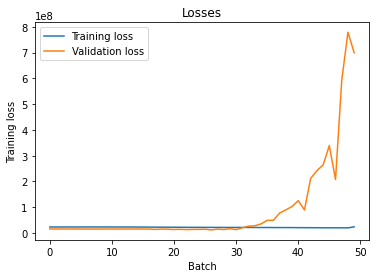

In [ ]:
counter = 0
for i in range(len(data_format_values)):
  for j in range(len(day_out_pred_values)):
    for k in range(len(seq_len_values)):
      for l in range(len(normalization_values)):
        print("----------" + str(counter) + "-----------")
        data_format = data_format_values[i]
        day_out_pred = day_out_pred_values[j]
        seq_len = seq_len_values[k]
        normalization = normalization_values[l]
        run_everything(False)
        counter = counter + 1
      
